# Mobile phone customer churn

*This notebook first appeared as a part of [forests-intro](https://github.com/wildtreetech/forests-intro).*

<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="Creative Commons License" style="border-width:0; display: inline" src="https://i.creativecommons.org/l/by-nc-sa/4.0/80x15.png" /></a><br /><span xmlns:dct="http://purl.org/dc/terms/" property="dct:title">Forests intro</span> by <a xmlns:cc="http://creativecommons.org/ns#" href="https://github.com/wildtreetech/forests-intro" property="cc:attributionName" rel="cc:attributionURL">Tim Head</a> is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>.

*Feel free to use, distribute, and modify with the above attribution.*

In [1]:
%config InlineBackend.figure_format='retina'
%matplotlib inline

import numpy as np
np.random.seed(123)
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams["font.size"] = 14
import pandas as pd

In [2]:
churn_df = pd.read_csv('churn.csv')

# A real mix of feature types

This data set consists of a mixed bag of features. Some are categories, some strings,
some numerical, ... with different scales/ranges.

Tree based methods are fairly robust against this. For Neural Networks you commonly
have to center and scale all your numerical features, figure out what to do with
categories, etc. No such preprocessing is needed here. Tree based models also deal
fairly well with "useless" features or repeated features. This means you can save
yourself the time of having to do feature removal if you have a lot of them. Or even
use the random forest you built to learn about the "important" features of your
data.

*Note: These statements come with all sorts of caveats, ask me over beer.*

In [3]:
churn_df.head().T

,0,1,2,3,4
State,KS,OH,NJ,OH,OK
Account Length,128,107,137,84,75
Area Code,415,415,415,408,415
Phone,382-4657,371-7191,358-1921,375-9999,330-6626
Int'l Plan,no,no,no,yes,yes
VMail Plan,yes,yes,no,no,no
VMail Message,25,26,0,0,0
Day Mins,265.1,161.6,243.4,299.4,166.7
Day Calls,110,123,114,71,113
Day Charge,45.07,27.47,41.38,50.9,28.34


## Chopping and reformatting in double speed

In the interest of time, just believe me that these are sensible things to do
to the data before feeding it to a random forest.

In [4]:
to_drop = ['State', 'Area Code', 'Phone', 'Churn?']
churn_features = churn_df.drop(to_drop, axis=1)

yes_no_columns = ["Int'l Plan", "VMail Plan"]
churn_features[yes_no_columns] = churn_features[yes_no_columns] == 'yes'

X = churn_features.as_matrix().astype(np.float)
y = np.where(churn_df['Churn?'] == 'True.', 1, 0)
print('Fraction of users leaving:', y.mean())

Fraction of users leaving: 0.144914491449


# Let's get predicting

Using what we learnt before we evaluate the performance of the model
using cross validation and compare it to a baseline.

In [5]:
from sklearn.cross_validation import cross_val_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier


# always remember, baselines!
classifiers = [('Dummy', DummyClassifier(strategy='most_frequent')),
               ('RF', RandomForestClassifier())]

In [6]:
for name,classifier in classifiers:
    scores = cross_val_score(classifier, X, y, scoring='accuracy')
    print(name, 'scores:', scores)

Dummy scores: [ 0.85508551  0.85508551  0.85508551]
RF scores: [ 0.93249325  0.94329433  0.94059406]


What happened here? The dummy classifier achieves a performance of 85%?

Most people do not switch mobile phone providers, so always predicting "no switch",
gets you a long way. This is why you need something to compare to.

For unbalanced datasets (like this one), `accuracy` is not a useful metric. Instead
look at something more sophisticated like:


# The Receiver Operating Characteristic

(Everyone just calls it ROC curve.)

This shows you for each possible "false positive rate" (FPR) what "true positive rate" (TPR)
you can achieve. Depending on your use-case you might want to have a small FPR or a very
large TPR.

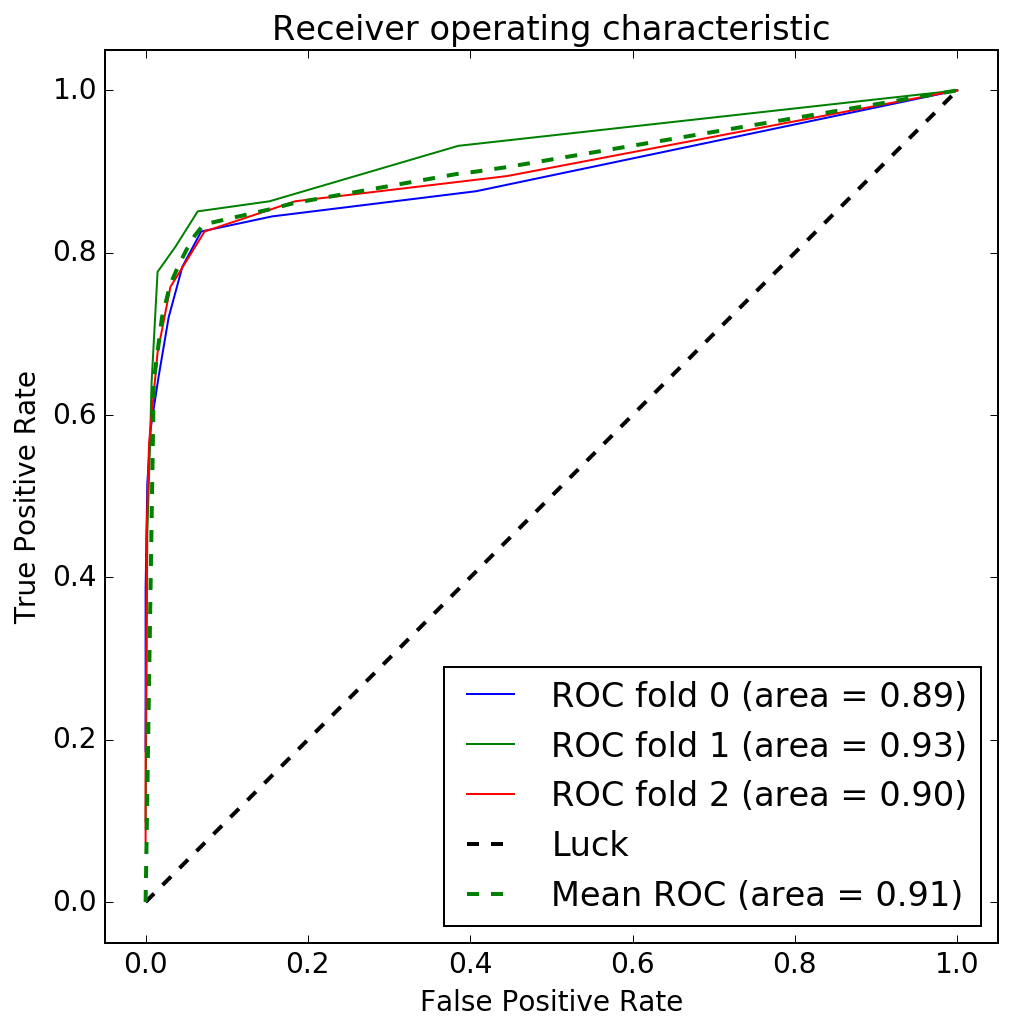

In [7]:
from sklearn.cross_validation import StratifiedKFold
from utils import draw_roc_curve

clf = RandomForestClassifier()
cv = StratifiedKFold(y, n_folds=3)
    
draw_roc_curve(clf, cv, X, y)

# Things to remember

* what is the baseline you are comparing to? How well would you do with a dummy classifier?
* cross-validation: keep data in reserve in order to evaluate the performance of your model
* accuracy is not the be all, end all
* can tune the false positive and false negative rate depending on what is important to you


# The End

All the material is available on github: https://github.com/wildtreetech/forests-intro

---

## Aside: Confusion matrix

Look at which classes your classifier gets wrong and in which direction. This can
tell you something about which cases are hard and which easy.

In [8]:
from sklearn.metrics import confusion_matrix
from sklearn.cross_validation import cross_val_predict

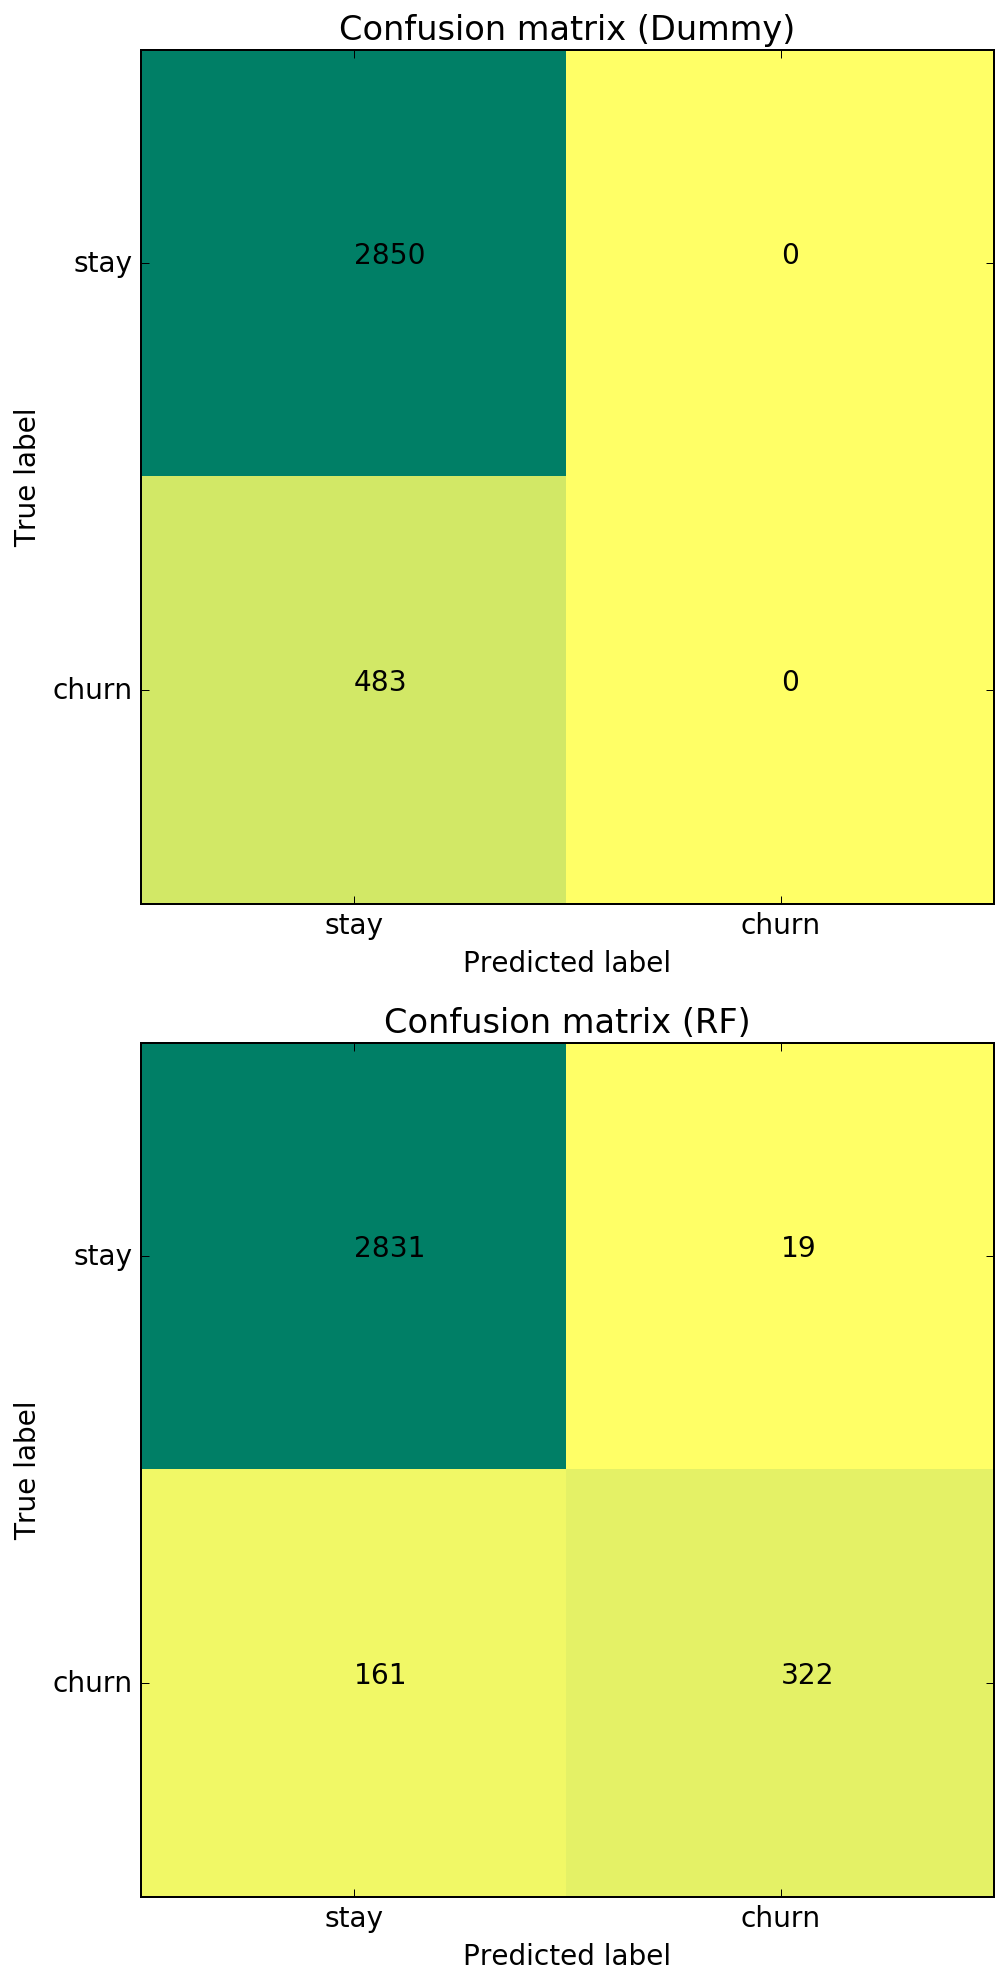

In [9]:
def plot_confusion_matrix(cm, ax, title='Confusion matrix', cmap=plt.cm.summer_r):
    ax.imshow(cm, interpolation='none', cmap=cmap)

    ax.set_xticks([0,1])
    ax.set_yticks([0,1])

    ax.set_xticklabels(['stay', 'churn'])
    ax.set_yticklabels(['stay', 'churn'])

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.annotate(str(cm[i][j]), xy=(j, i), color='black')

    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    ax.set_title(title)


fig, axarr = plt.subplots(nrows=len(classifiers), figsize=(7, 7*len(classifiers)))

for (name,classifier), ax in zip(classifiers, axarr):
    y_pred = cross_val_predict(classifier, X, y)
    plot_confusion_matrix(confusion_matrix(y, y_pred), ax,
                          'Confusion matrix (%s)'%name)
    
plt.tight_layout()